In [18]:
# 1. 기본 설정 / 라이브러리
import pandas as pd
import matplotlib.pyplot as plt

# 자동 그래프 표시
%matplotlib inline

RESULTS_FILE = "results.csv"


In [19]:
df = pd.read_csv(RESULTS_FILE)
df


,name,algo,mode,use_gpu,n_workers,scale,total_time_sec
0,A2C_CPU,A2C,sync,False,4,200,3.254258
1,A2C_GPU,A2C,sync,True,4,200,3.650367
2,A3C_CPU,A3C,async,False,4,800,3.186400
3,A3C_GPU,A3C,async,True,4,800,33.137308


In [20]:
# use_gpu를 사람이 보기 좋은 문자열로 변환
df["device"] = df["use_gpu"].map({True: "GPU", False: "CPU"})

# time per unit (scale 기준 정규화)
df["time_per_unit"] = df["total_time_sec"] / df["scale"]

df


,name,algo,mode,use_gpu,n_workers,scale,total_time_sec,device,time_per_unit
0,A2C_CPU,A2C,sync,False,4,200,3.254258,CPU,0.016271
1,A2C_GPU,A2C,sync,True,4,200,3.650367,GPU,0.018252
2,A3C_CPU,A3C,async,False,4,800,3.186400,CPU,0.003983
3,A3C_GPU,A3C,async,True,4,800,33.137308,GPU,0.041422


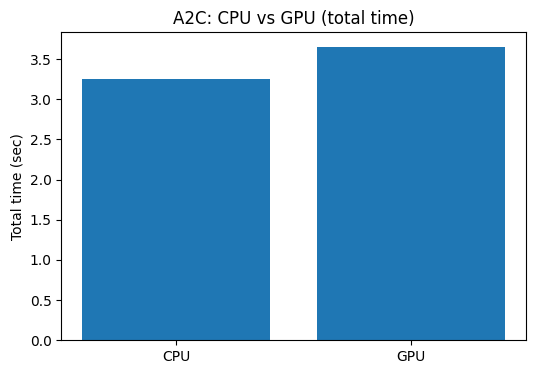

,name,device,total_time_sec
0,A2C_CPU,CPU,3.254258
1,A2C_GPU,GPU,3.650367


In [21]:
a2c = df[df["algo"] == "A2C"].copy()

plt.figure(figsize=(6, 4))
plt.bar(a2c["device"], a2c["total_time_sec"])
plt.title("A2C: CPU vs GPU (total time)")
plt.ylabel("Total time (sec)")
plt.show()

a2c[["name", "device", "total_time_sec"]]


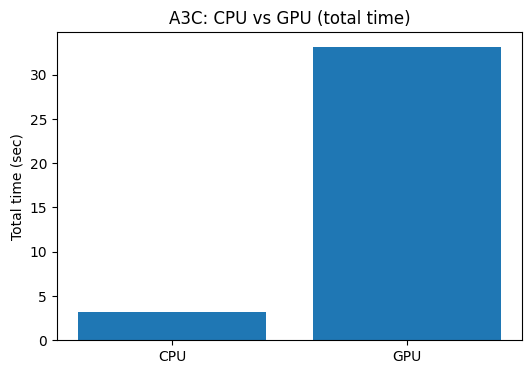

,name,device,total_time_sec
2,A3C_CPU,CPU,3.186400
3,A3C_GPU,GPU,33.137308


In [22]:
a3c = df[df["algo"] == "A3C"].copy()

plt.figure(figsize=(6, 4))
plt.bar(a3c["device"], a3c["total_time_sec"])
plt.title("A3C: CPU vs GPU (total time)")
plt.ylabel("Total time (sec)")
plt.show()

a3c[["name", "device", "total_time_sec"]]


#### A2C vs A3C, time_per_unit 비교 (scale 정규화)

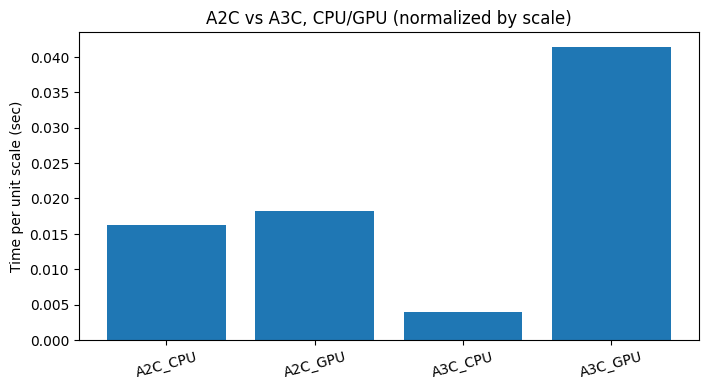

,name,algo,device,scale,total_time_sec,time_per_unit
0,A2C_CPU,A2C,CPU,200,3.254258,0.016271
1,A2C_GPU,A2C,GPU,200,3.650367,0.018252
2,A3C_CPU,A3C,CPU,800,3.186400,0.003983
3,A3C_GPU,A3C,GPU,800,33.137308,0.041422


In [23]:
plt.figure(figsize=(8, 4))

labels = df["name"]
x = range(len(labels))

plt.bar(x, df["time_per_unit"])
plt.xticks(x, labels, rotation=15)
plt.ylabel("Time per unit scale (sec)")
plt.title("A2C vs A3C, CPU/GPU (normalized by scale)")
plt.show()

df[["name", "algo", "device", "scale", "total_time_sec", "time_per_unit"]]


### A2C (Synchronous Advantage Actor-Critic)

- Actor N개는 병렬로 환경 상호작용만 수행

- Learner는 trajectory N개를 batch로 받아 한 번에 학습

- GPU 활용에 적합 (큰 batch 처리)

- 모든 actor가 업데이트 시점을 공유 → 동기 방식

### A3C (Asynchronous Advantage Actor-Critic)
 
- 각 worker가 독립적으로 rollout + local backward 수행

- Global network는 shared memory 기반으로 비동기 업데이트

- CPU 멀티프로세싱에 적합

- Replay Buffer 불필요

- 서로 다른 환경 trajectory로 decorrelation 효과

#### 실험환경

OS: Windows 10 / Python 3.11

Library: PyTorch, Gymnasium

Environment: CartPole-v1

Hardware:

- CPU: (작성)

- GPU: GeForce RTX 5080

#### Cartpole & GPU 사용 시 문제점

CartPole과 같이 경량 환경에서는 A3C 구조가 생성하는 local update의 granularity가 너무 작아 GPU 장점이 전혀 발휘되지 않는다.

A3C는 각 worker가 매우 작은 trajectory(t_max=5)에 대해 local backward를 수행하므로 GPU kernel launch 오버헤드가 누적되어 성능이 저하된다.

또한 A3C는 global parameter가 CPU memory에 존재하며, worker에서 매 업데이트마다 CPU↔GPU 파라미터 및 gradient 동기화 비용이 발생하여 전체 학습 시간이 증가하였다.

결과적으로 GPU를 사용한 A3C는 CPU 대비 약 10배 이상 느린 성능을 보였으며, 이는 기존 연구에서 제시된 “A3C는 CPU 멀티프로세싱 기반으로 설계됨”이라는 구조적 특성과 일치한다.